<h1 style = 'color:blue'> Extraer info de las regiones propuesta</h1>

In [1]:
# Cargar librerias
from torch_snippets import *
import selectivesearch
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import pickle
import time
import gc
import warnings
warnings.filterwarnings('ignore')

#device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device

2021-07-31 15:23:21.424 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-07-31 15:23:22.089 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [2]:
# Declarar rutas
image_root = '../Data/Coleccion-de-imagenes-master/Imagenes' # Carpeta donde se encuentran las imágenes
anotc_root = '../Data/Coleccion-de-imagenes-master/Anotaciones'

In [3]:
df_bbox = pd.read_csv('../Outputs/df_raw.csv')
df_bbox.head(2)

,filename,width,height,depth,label,pose,truncated,difficult,xmin,ymin,xmax,ymax
0,imagen_0001.png,1280,720,3,Excavadora,NaN,0,0,591,323,1170,567
1,imagen_0001.png,1280,720,3,Auto,NaN,0,0,25,476,320,666


----------
<h2 style = 'color:orange'>1. Preparación de datos</h2>
    Se declaran las funciones necesarias para cargar los datos tanto de las imágenes, sus etiquetas y bbox
--------

In [4]:
# Definir una clase para leer las imágenes con sus repectivos clases y bbox 

In [5]:
class OpenImages(Dataset):
    """Leemos la data de la imagen su etiqueta y los cuadros donde aparecen los objetos"""
    def __init__(self, df, image_folder = image_root):
        self.root = image_folder
        self.df = df
        self.unique_images = df['filename'].unique()
        
    def __len__(self):
        return len(self.unique_images)
    
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        print(image_id)
        image_path = f'{self.root}/{image_id}'
        #Convert to BGR to RGB
        image = cv2.imread(image_path,1)[...,::-1]
        h,w,_ = image.shape # Extract dimensiones of images
        df = self.df.copy()
        df = df[df['filename'] == image_id]
        boxes = df['xmin,ymin,xmax,ymax'.split(',')].values
        #boxes = (boxes*np.array([w,h,w,h])).tolist()#.astype(np.uint16) # No es neceario con data sin escalar
        classes = df['label'].values.tolist()
        return image, boxes, classes, image_path   

imagen_0010.png


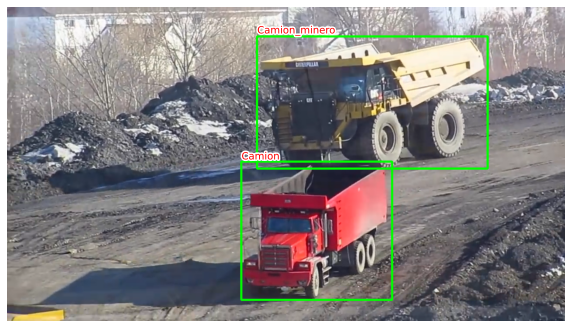

In [6]:
ds = OpenImages(df = df_bbox)
im, bbs, clss, _ = ds[9]
show(im, bbs = bbs, texts = clss, sz = 10)

imagen_0834.png


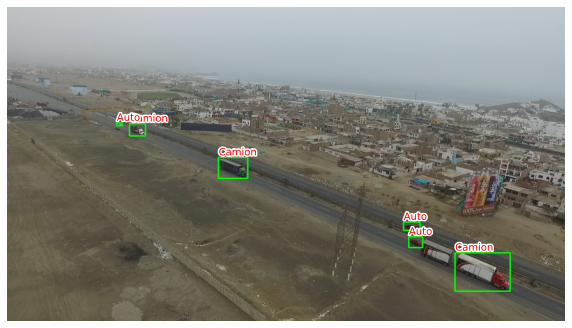

In [7]:
ds = OpenImages(df = df_bbox)
im, bbs, clss, _ = ds[833]
show(im, bbs = bbs, texts = clss, sz = 10)

imagen_1277.png


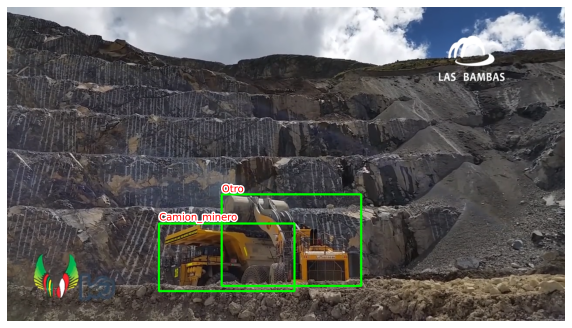

In [8]:
ds = OpenImages(df = df_bbox)
im, bbs, clss, _ = ds[1276]
show(im, bbs = bbs, texts = clss, sz = 10)

In [9]:
# Además definimos dos funciones adicionales para extraer regiones candidatas con sus repectivos IoU

In [10]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale = 200, min_size = 100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x,y,w,h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

def extract_iou(boxA, boxB, epsilon = 1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2-y1)
    
    if (width<0) or (height<0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined + epsilon)
    return iou

----------------------
<h2 style = 'color:orange'>2. Obtención de las regiones propuestas y su desplazamiento correcto</h2> 
se va a crear los valores de entrada y salida de la red.     

- La entrada lo constituyen los candidatos que se extraen mediante el método de <b>búsqueda selectiva</b>   
- Y la salida lo constituyen la clase correspondiente a los candidatos y el desplazamiento del candidato con respecto al cuadro delimitador con el que más se superpone, si el candidato contiene un objeto.

----------

In [11]:
print('Cantidad de imágenes: ', df_bbox.filename.nunique())

Cantidad de imágenes:  1572


In [12]:
%%time
# Inicializar listas vacías para: FPATHS[Directorio de trabajo], GTBBS[ground truth bounding boxes], CLSS[clases], DELTAS[delta offset of a bounding box with region proposal], ROIS[region proposal locations], IOUS[IoU of region proposals with ground truths]
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []

N = df_bbox.filename.nunique() # Extraer información de todas la imágenes

# Bucle para recorrer el dataset de imagenes y completar listas vacías
for ix, (im, bbs, labels, fpath) in tqdm_notebook(enumerate(ds)):
    if (ix == N):
        break
    #--------- Extract candidates for each images
    H, W, _ = im.shape
    candidates = extract_candidates(im)
    candidates = np.array([(x,y, x+w, y+h) for x,y,w,h in candidates])
    #---------- Initialize ious, rois, deltas and clss
    ious, rois, clss, deltas = [], [], [], []
    #---------- Store the IoU of all candidates 
    ious = np.array([[extract_iou(candidate, __bb__) for candidate in candidates] for __bb__ in bbs]).T
    #---------- Loop through each candidate an store
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        #------ Extract the IoU corresponding to the candidate
        candidate_ious = ious[jx]
        #------ Find the index of candidate
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X, _Y = bbs[best_iou_at]
        #------ If IoU (best_iou) is greater than a threshold (0.3)
        if best_iou > 0.3:
            clss.append(labels[best_iou_at])
        else:
            clss.append('background')
        #-------- Current proposal be adjusted
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    #-------- append empty lists
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
    gc.collect()
#------- Store all information
FPATHS = [f'{image_root}/{stem(f)}.png' for f in FPATHS]
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS, DELTAS, ROIS]]



0it [00:00, ?it/s]

imagen_0001.png
imagen_0002.png
imagen_0003.png
imagen_0004.png
imagen_0005.png
imagen_0006.png
imagen_0007.png
imagen_0008.png
imagen_0009.png
imagen_0010.png
imagen_0011.png
imagen_0012.png
imagen_0013.png
imagen_0014.png
imagen_0015.png
imagen_0016.png
imagen_0017.png
imagen_0018.png
imagen_0019.png
imagen_0020.png
imagen_0021.png
imagen_0022.png
imagen_0023.png
imagen_0024.png
imagen_0025.png
imagen_0026.png
imagen_0027.png
imagen_0028.png
imagen_0029.png
imagen_0030.png
imagen_0031.png
imagen_0032.png
imagen_0033.png
imagen_0034.png
imagen_0035.png
imagen_0036.png
imagen_0037.png
imagen_0038.png
imagen_0039.png
imagen_0040.png
imagen_0041.png
imagen_0042.png
imagen_0043.png
imagen_0044.png
imagen_0045.png
imagen_0046.png
imagen_0047.png
imagen_0048.png
imagen_0049.png
imagen_0050.png
imagen_0051.png
imagen_0052.png
imagen_0053.png
imagen_0054.png
imagen_0055.png
imagen_0056.png
imagen_0057.png
imagen_0058.png
imagen_0059.png
imagen_0060.png
imagen_0061.png
imagen_0062.png
imagen_0

In [15]:
FPATHS

['../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0001.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0002.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0003.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0004.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0005.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0006.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0007.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0008.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0009.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0010.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0011.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0012.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0013.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0014.png',
 '../Data/Coleccion-de-imagenes-master/Imagenes/imagen_0015.png',
 '../Data/

In [16]:
# Save listas
for k, v in dict({'FPATHS':FPATHS, 'GTBBS':GTBBS, 'CLSS':CLSS, 'DELTAS':DELTAS, 'ROIS':ROIS}).items():
    with open("../Outputs/{}.txt".format(k), "wb") as fp:   #Pickling
        pickle.dump(v, fp)

import pickle
# Read listas
  
with open("../Outputs/FPATHS.txt".format(k), "rb") as fp:   #Pickling
  FPATH = pickle.load(fp)
with open("../Outputs/GTBBS.txt".format(k), "rb") as fp:   #Pickling
  GTBB = pickle.load(fp)
with open("../Outputs/CLSS.txt".format(k), "rb") as fp:   #Pickling
  CLS = pickle.load(fp)
with open("../Outputs/DELTAS.txt".format(k), "rb") as fp:   #Pickling
  DELTA = pickle.load(fp)
with open("../Outputs/ROIS.txt".format(k), "rb") as fp:   #Pickling
  ROI = pickle.load(fp)

#with open("test.txt", "rb") as fp:   # Unpickling
#  b = pickle.load(fp)

del FPATHS, GTBBS, CLSS,  DELTAS, ROIS